## В классе
Придумать спецификацию класса агента – игрока

In [1]:
WEIGHT_FROM_FILE = False
p = 0.3
alpha = 0.5
update_before_rndom_move = True

In [2]:
class AgentTicTac:
    def __init__(self, is_zero):
    #is_zero == True если нолик
        self.is_zero = True
        self.label = int(not is_zero)
        self.way = []
        if WEIGHT_FROM_FILE:
            self.state_matrix = pd.read_csv('weight{}.csv'.format(self.label), dtype={'states': object}).set_index('states')
            self.state_matrix['possible_moves'] = self.state_matrix['possible_moves'].apply(lambda x: ast.literal_eval(x))
        else:
            self.state_matrix = state_generate(self.is_zero)
    def get_action(self, state):
    # пример state = [[1,0,1],[0,1,0],[0,1,0]] 1 - это крестик, 0 - это нолик, -1 - пусто
        now_state = self.state_matrix.loc[get_code_from_state(state)]
        pos_move = pd.DataFrame(now_state['possible_moves'])
        if np.random.random() < p:
            new_state = pos_move.sample(n = 1).iloc[0]
            new_state_value = self.state_matrix.loc[new_state['state'], 'value']
            self.way.append(((now_state.name, now_state.value), (new_state['state'], new_state_value)))
            #self.state_matrix.loc[get_code_from_state(state), 'value'] = now_state['value'] + alpha*(new_state_value -
            #                                                                                         now_state['value'])
            return new_state['move']
        else:
            pos_move['value'] = pos_move['state'].apply(lambda x: self.state_matrix.loc[x, 'value'])
            new_state = pos_move[pos_move['value']==pos_move['value'].max()].iloc[0]
            new_state_value = self.state_matrix.loc[new_state['state'], 'value']
            self.way.append(((now_state.name, now_state.value), (new_state['state'], new_state_value)))
            #self.state_matrix.loc[get_code_from_state(state), 'value'] = now_state['value'] + alpha*(new_state['value'] -
            #                                                                                         now_state['value'])
            return new_state['move']
    def save_weight(self):
        self.state_matrix.to_csv('weight{}.csv'.format(self.label))
    def is_done(self, state, reward):
        if reward == 1:
            for move in self.way[::-1]:
                self.state_matrix.loc[move[0][0], 'value'] = move[0][1] + alpha*(move[1][1] -move[0][1])
    # reward - вознаграждение 1 если выиграли , вызывается когда игра закончена
        
class AgentTicTac_e:
    def __init__(self, is_zero, parent_weights):
    #is_zero == True если нолик
        self.is_zero = True
        self.label = int(not is_zero)
        if parent_weights:
            self.state_matrix = #Тут твоя функция, которая меняет веса
        else:
            if WEIGHT_FROM_FILE:
                self.state_matrix = pd.read_csv('weight_e{}.csv'.format(self.label), dtype={'states': object}).set_index('states')
                self.state_matrix['possible_moves'] = self.state_matrix['possible_moves'].apply(lambda x: ast.literal_eval(x))
            else:
                self.state_matrix = #Тут твоя функция, которая генерирует случайную матрицу от parent_weights
    def get_action(self, state):
        now_state = self.state_matrix.loc[get_code_from_state(state)]
        pos_move = pd.DataFrame(now_state['possible_moves'])
        pos_move['value'] = pos_move['state'].apply(lambda x: self.state_matrix.loc[x, 'value'])
        new_state = pos_move[pos_move['value']==pos_move['value'].max()].iloc[0]
        return new_state['move']
    def save_weight(self):
        self.state_matrix.to_csv('weight_e{}.csv'.format(self.label))
    def is_done(self, state, reward):
        return 0
        

## Дома
Написать класс, который берет два экземпляра классов агентов и играет

Реализовать игроков на на основе обучения с подкреплением и эволюционного подхода

Поведём состязание

Проверить: как лучше – корректировать ценности после всех ходов или только "жадных"?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast

In [4]:
#проверка победы
def check_win(state, label):
    for i in range(3):
        if np.all(state[i,:] == int(label)):
            return True
        elif np.all(state[:,i] == int(label)):
            return True
    if np.all(np.fliplr(state).diagonal() == int(label)):
        return True
    if np.all(state.diagonal() == int(label)):
        return True
    return False

#вывод поля состояния в виде матрицы
def get_state_from_code(code):
    return np.array(re.findall(r'\d', code)).reshape((3,3)).astype('int')-1

#
def get_code_from_state(state):
    result = ''
    for s in (state.flatten()+1).astype('str'):
        result += s
    return result


## функция выбора след.хода

скопировала твой гениратор и добавила своего кода, поправь пожалст, а то прям видно что писал недопрограммист))

In [5]:
#получаем индексы свободных полей
def get_free_field(state):
    index = []
    for i in range(3):
        for j in range(3):
            if state[i][j]==-1:
                index.append((i,j))
    return index

In [6]:
#получение списка следующих возможных ходов
def get_possible_state(state, label):
    pos_state = []
    index = get_free_field(state)
    for i,j in index:
        s=state
        s[i][j]=label
        pos_state.append(get_code_from_state(s))
    return pos_state

In [7]:
#следующие возможные ходы, может я твой код не так понял, но у меня он что-то странное выдавал
def get_possible_move_from_code(state, label):
    label = str(int(label)+1)
    states = {'state':[], 'move':[]}
    for i in range(len(state)):
        if state[i]=='0':
            states['state'].append(state[:i]+label+state[i+1:])
            states['move'].append(((i)//3,i%3))
    return states

In [59]:
#генирация состояний со следующими ходами
#гениратор состояний
def state_generate(label):
    states = []
    values = []
    for i in range(19683):
        s = np.base_repr(i,base=3)
        s = '0'*(9-len(s)) + s
        states.append(s)
        if check_win(get_state_from_code(s), label):
            values.append(1)
        else:
            values.append(0.5)
    states = np.array(states)
    pos_st = []
    for state_code in states:
        pos_st.append(get_possible_move_from_code(state_code, label))
    return pd.DataFrame({'states':states, 'value':values,'possible_moves':pos_st}).set_index('states')

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
#проведение 1 раунда
def two_came_in_one_came_out(agent_zeros, agent_ones, print_state = False):
    state = (np.zeros((3,3))-1).astype('int')
    while -1 in state:
        #ход креста
        state[agent_ones.get_action(state)] = 1
        if print_state:
            print(state)
            print()
        if check_win(state, 1):
            agent_ones.is_done(state, True)
            agent_zeros.is_done(state, False)
            return 1
        if not(-1 in state):
            break
        state[agent_zeros.get_action(state)] = 0
        if print_state:
            print(state)
            print()
        if check_win(state, 0):
            agent_ones.is_done(state, False)
            agent_zeros.is_done(state, True)
            return 0
    agent_ones.is_done(state, False)
    agent_zeros.is_done(state, False)
    return -1
def fit(agent_zeros, agent_ones, epochs, step_per_epoch, save_config = False, plot_win = False):
    history = {
        'epoch':[],
        'zeros win':[],
        'ones win':[],
        'draw':[]
    }
    for epoch in tqdm(np.arange(epochs)):
        z_win = 0
        o_win = 0
        draw = 0
        for step in np.arange(step_per_epoch):
            play_result = two_came_in_one_came_out(agent_zeros, agent_ones)
            if play_result == 0:
                z_win += 1
            elif play_result == 1:
                o_win += 1
            else:
                draw += 1
        history['epoch'].append(epoch)
        history['zeros win'].append(z_win)
        history['ones win'].append(o_win)
        history['draw'].append(draw)
    history = pd.DataFrame(history)
    if plot_win:
        plt.figure(figsize=(10, 8))
        plt.plot(history['epoch'], (history['zeros win']/step_per_epoch)*100, 'b-', label = '% побед нуля в эпохе')
        plt.plot(history['epoch'], (history['ones win']/step_per_epoch)*100, 'r-', label = '% побед креста в эпохе')
        plt.plot(history['epoch'], (history['draw']/step_per_epoch)*100, 'k--', label = '% ничей в эпохе')
        plt.xlim([0,epochs])
        plt.ylim([0,101])
        plt.grid()
        plt.legend()
        plt.show()
    if save_config:
        agent_ones.save_weight()
        agent_zeros.save_weight()

In [11]:
get_state_from_code('222211010')

array([[ 1,  1,  1],
       [ 1,  0,  0],
       [-1,  0, -1]])

In [12]:
get_code_from_state(np.array([[ 1,  1,  1],[ 1,  0,  0], [-1, -1, -1]]))

'222211000'

In [13]:
get_possible_move_from_code('222211000', 1)

{'state': ['222211200', '222211020', '222211002'],
 'move': [(2, 0), (2, 1), (2, 2)]}

In [14]:
get_possible_move_from_code('000000000', 0)

{'state': ['100000000',
  '010000000',
  '001000000',
  '000100000',
  '000010000',
  '000001000',
  '000000100',
  '000000010',
  '000000001'],
 'move': [(0, 0),
  (0, 1),
  (0, 2),
  (1, 0),
  (1, 1),
  (1, 2),
  (2, 0),
  (2, 1),
  (2, 2)]}

In [15]:
state_generate(False).head() #нули

,value,possible_moves
states,,
000000000,0.5,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.5,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.5,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.5,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.5,"{'state': ['100000011', '010000011', '00100001..."


In [16]:
state_generate(True).head() #кресты

,value,possible_moves
states,,
000000000,0.5,"{'state': ['200000000', '020000000', '00200000..."
000000001,0.5,"{'state': ['200000001', '020000001', '00200000..."
000000002,0.5,"{'state': ['200000002', '020000002', '00200000..."
000000010,0.5,"{'state': ['200000010', '020000010', '00200001..."
000000011,0.5,"{'state': ['200000011', '020000011', '00200001..."


#### 1 Раунд

In [62]:
zeros = AgentTicTac(True)
ones = AgentTicTac(False)

In [63]:
#1 - победа креста, 0 - победа нуля, -1 - ничья
two_came_in_one_came_out(zeros, ones, print_state = True)

[[ 1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]

[[ 1 -1 -1]
 [ 0 -1 -1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 0 -1 -1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 0  0 -1]
 [-1 -1 -1]]

[[ 1  1  1]
 [ 0  0 -1]
 [-1 -1 -1]]



1

100%|████████████████████████████████████████| 100/100 [20:14<00:00, 11.25s/it]


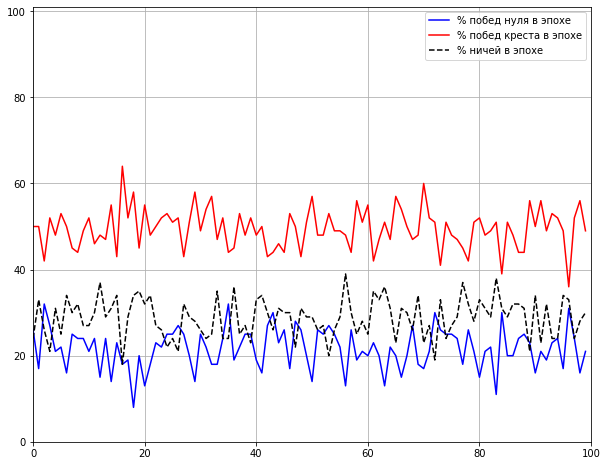

In [66]:
zeros = AgentTicTac(True)
ones = AgentTicTac(False)
fit(zeros, ones, epochs = 100, step_per_epoch = 100, save_config = True, plot_win = True)

## Эволюционный подход

In [10]:
#Начальная инициализация
#Случайное распределение весов у стратегий
import numpy as np
#генирация состояний со следующими ходами
#гениратор состояний
def state_generate_evolut(label):
    states = []
    values = []
    for i in range(19683):
        s = np.base_repr(i,base=3)
        s = '0'*(9-len(s)) + s
        states.append(s)
        if check_win(get_state_from_code(s), label):
            values.append(1)
        else:
            values.append(np.random.sample())
    states = np.array(states)
    pos_st = []
    for state_code in states:
        pos_st.append(get_possible_move_from_code(state_code, label))
    return pd.DataFrame({'states':states, 'value':values,'possible_moves':pos_st}).set_index('states')

In [58]:
s = state_generate(False)
s.head()

,value,possible_moves
states,,
000000000,0.495245,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.565389,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.368132,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.489431,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.176905,"{'state': ['100000011', '010000011', '00100001..."


In [46]:
s.index[1]

'000000001'

In [62]:
# типо изменение весов
#perc – доля объектов, которые надо изменить
def change_states_val(state_tab, perc, bound):
    state_table = state_tab.copy()
    
    rows_cnt = round(state_table.shape[0] * perc,)
    ind_ch = np.random.randint(0, state_table.shape[0], rows_cnt)
    for i in ind_ch:
        state_table.loc[state_table.index[i],'value'] = (state_table.loc[state_table.index[i],'value'] 
                                                +(np.random.random() - .5)*2*bound)
    return state_table

In [64]:
change_states_val(s, 0.7, 0.1).head()

,value,possible_moves
states,,
000000000,0.495245,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.565389,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.358774,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.489431,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.083735,"{'state': ['100000011', '010000011', '00100001..."
